In [1]:
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import seaborn as sns
from tqdm import trange




print("pyTorch Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Count:", torch.cuda.device_count())
    print("CUDA Current Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
        

    print("pyTorch Version: ", torch.__version__)
    print("pyTorch CUDA Version: ", torch.version.cuda)
#torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

pyTorch Available: False
cpu


### Generate Datasets: Spiral Dataset, Half Moon Dataset & SwissRoll Dataset

In [2]:
def generate_swiss_roll(n_samples=100000, noise=0.1):
    X, t = make_swiss_roll(n_samples=n_samples, noise=noise)
    return torch.tensor(np.stack((X[:, 0], X[:, 1], X[:, 2]), axis=-1), dtype=torch.float32),t

swissroll_data,t = generate_swiss_roll()

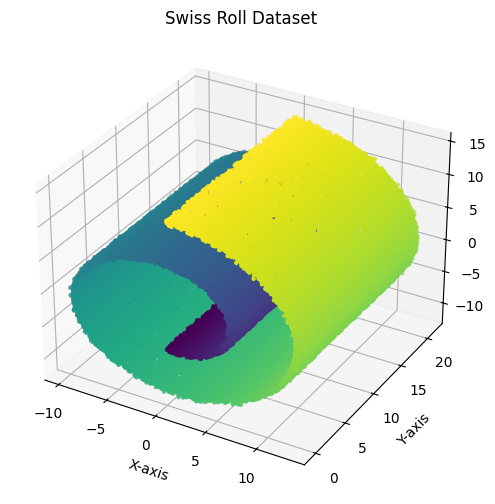

[12.1401609  13.389292    6.22608205 ... 10.05351876 10.03051798
 11.93700199]


In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(swissroll_data[:, 0], swissroll_data[:, 1], swissroll_data[:, 2], c=t, cmap="viridis", s=5)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Swiss Roll Dataset")
plt.show()
print(t)

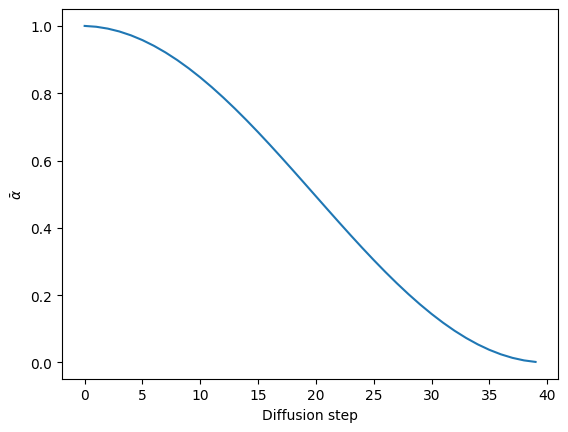

In [4]:
diffusion_steps = 40  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

### Test adding noise

In [5]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

In [6]:
noiselevel = 20

noised_swissroll_data, eps = noise(swissroll_data, torch.full([len(swissroll_data), 1], fill_value=noiselevel))

In [20]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(swissroll_data[:, 0], swissroll_data[:, 1], swissroll_data[:, 2], c=t, alpha=0.5, label="Original Data")
# ax.set_xlabel("X-axis")
# ax.set_ylabel("Y-axis")
# ax.set_zlabel("Z-axis")
# ax.set_title("Original Swiss Roll Dataset")
# ax.legend()

# plt.show()

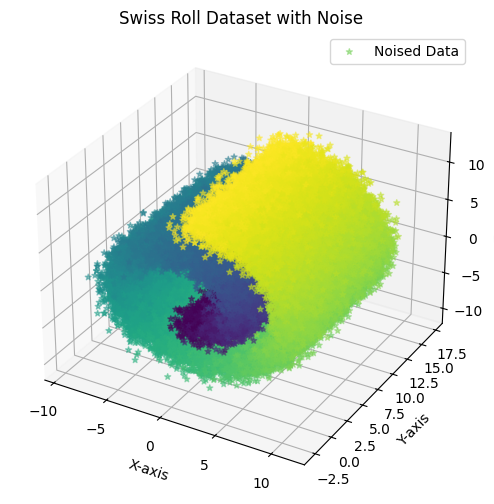

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot for noised Swiss Roll data
ax.scatter(noised_swissroll_data[:, 0], noised_swissroll_data[:, 1], noised_swissroll_data[:, 2], c=t, marker="*", alpha=0.5, label="Noised Data")
# Scatter plot for original Swiss Roll data
# ax.scatter(swissroll_data[:, 0], swissroll_data[:, 1], swissroll_data[:, 2], alpha=0.5, label="Original Data")

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Swiss Roll Dataset with Noise")
ax.legend()

plt.show()

### Diffusion Network

In [8]:
class DiffusionBlock(nn.Module):
    def __init__(self, hidden_layer, dropout_prob=0.1):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(hidden_layer, hidden_layer)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, hidden_layer = 64, dropout_prob=0.1):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, hidden_layer)
        self.midblocks = nn.ModuleList([DiffusionBlock(hidden_layer) for _ in range(nblocks)])
        self.dropout = nn.Dropout(dropout_prob)
        self.outblock = nn.Linear(hidden_layer, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.dropout(val)
        val = self.outblock(val)
        return val

### Training Diffusion Model Swiss Roll Data

In [9]:
swissroll_model = DiffusionModel(nfeatures=3, nblocks=6, hidden_layer=256)

#device = "cuda"
swissroll_model = swissroll_model.to(device)

print(swissroll_model)

DiffusionModel(
  (inblock): Linear(in_features=4, out_features=256, bias=True)
  (midblocks): ModuleList(
    (0-5): 6 x DiffusionBlock(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (outblock): Linear(in_features=256, out_features=3, bias=True)
)


In [10]:
epochs = 100
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(swissroll_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=epochs)

for epoch in range(epochs):
    epoch_loss = steps = 0
    for i in range(0, len(swissroll_data), batch_size):
        Xbatch = swissroll_data[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = swissroll_model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.9562929272651672
Epoch 10 loss = 0.8857998847961426
Epoch 20 loss = 0.8074713945388794
Epoch 30 loss = 0.7815370559692383
Epoch 40 loss = 0.7580307126045227
Epoch 50 loss = 0.7453550100326538
Epoch 60 loss = 0.7297278642654419
Epoch 70 loss = 0.7284393310546875
Epoch 80 loss = 0.7299140691757202
Epoch 90 loss = 0.7242879867553711


In [11]:
def sample_ddpm(model, nsamples, nfeatures, mc_samples=30):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    model.train()
    samples = torch.zeros(mc_samples, nsamples, nfeatures).to(device)
    with torch.no_grad():
        for i in range(mc_samples):
            x = torch.randn(size=(nsamples, nfeatures)).to(device)
            xt = [x]
            for t in range(diffusion_steps-1, 0, -1):
                predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
                # See DDPM paper between equations 11 and 12
                x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
                if t > 1:
                    # See DDPM paper section 3.2.
                    # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                    variance = betas[t]
                    std = variance ** (0.5)
                    x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
                xt += [x]
            samples[i] = x
    return x, xt, samples

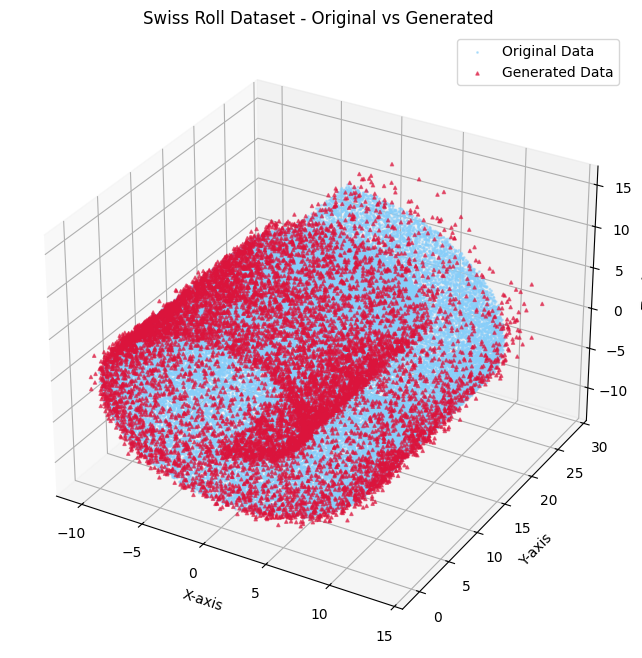

In [13]:
Xgen_swissroll, Xgen_hist_swissroll, samples = sample_ddpm(swissroll_model, 10000, 3)
Xgen_swissroll = Xgen_swissroll.cpu()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(swissroll_data[:, 0], swissroll_data[:, 1], swissroll_data[:, 2], c="lightskyblue", s=1, alpha=0.5, label="Original Data")

ax.scatter(Xgen_swissroll[:, 0], Xgen_swissroll[:, 1], Xgen_swissroll[:, 2], c="crimson", s=5, marker="^", alpha=0.6, label="Generated Data")

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Swiss Roll Dataset - Original vs Generated")
ax.legend()

plt.show()

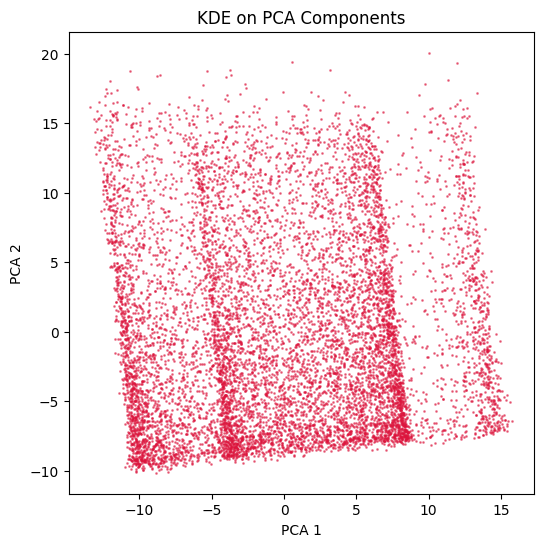

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

# Flatten all samples (shape: (30*num_points, D))
D = Xgen_swissroll.shape[1]  # Number of dimensions
flattened_samples = Xgen_swissroll.reshape(-1, D)  # Shape: (30*num_points, D)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_samples)

# KDE on PCA components
plt.figure(figsize=(6, 6))
#sns.kdeplot(x=pca_result[:, 0], y=pca_result[:, 1], cmap="coolwarm", fill=True)
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=1, c="crimson", alpha=0.5)
plt.title("KDE on PCA Components")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

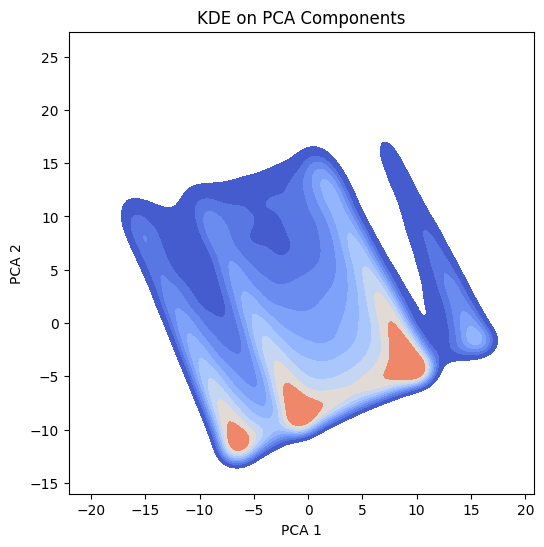

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns

# Flatten all samples (shape: (30*num_points, D))
D = samples.shape[2]  # Number of dimensions
flattened_samples = samples.reshape(-1, D)  # Shape: (30*num_points, D)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_samples)

# KDE on PCA components
plt.figure(figsize=(6, 6))
sns.kdeplot(x=pca_result[:, 0], y=pca_result[:, 1], cmap="coolwarm", fill=True)
plt.title("KDE on PCA Components")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()